# DATASCI 347: Machine Learning (Fall 2025)
## Instructor: Alexander Williams Tolbert
## Lecture: Model Selection

## Upload Dataset to Google Colab

Since we are working in Google Colab, we must first upload the dataset file (`Hitters.csv`). Run the following cell and choose the file from your local computer.

In [2]:
from google.colab import files        # import Colab's file upload tool
uploaded = files.upload()             # open a file chooser to upload local files

# After uploading, the dataset can be read normally with pandas:
# hitters = pd.read_csv("Hitters.csv", index_col=0)

Saving Hitters.csv to Hitters.csv


When you execute the cell above, Google Colab opens a browser dialog allowing you to select a file from your computer. Once uploaded, the file is stored in the session's temporary working directory. The `files.upload()` function returns a dictionary where keys are filenames and values are the file contents. After the upload completes, you can use `pd.read_csv()` to load the CSV file into a pandas DataFrame. The `index_col=0` parameter tells pandas to use the first column (player names) as the row index rather than creating a default numeric index.

## Install ISLP Package

Before we can use the ISLP library for model selection, we need to install it in our Colab environment. The following cell uses the pip package manager to install the library.

In [4]:
!pip install ISLP        # ! runs shell command in Colab
                         # pip is Python package installer
                         # install downloads and installs ISLP library

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=898d7538893428398aad4ee6c7191421c26410900730285f3f0bb2f0e855d263
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


The exclamation point `!` tells Colab to execute the command in the system shell rather than as Python code. The `pip install` command downloads the ISLP (Introduction to Statistical Learning with Python) package from the Python Package Index and installs it along with all its dependencies. You only need to run this once per Colab session. After installation completes, we can import functions from ISLP in subsequent cells.

## Import Required Libraries

Before we begin our analysis, we need to import the necessary Python libraries for data manipulation, visualization, and statistical modeling.

In [3]:
import numpy as np                              # numpy for numerical operations
import pandas as pd                             # pandas for data manipulation
import matplotlib.pyplot as plt                 # matplotlib for plotting
from matplotlib.pyplot import subplots          # subplots function for multiple plots
import seaborn as sns                           # seaborn for statistical visualizations
import statsmodels.api as sm                    # statsmodels for statistical models
import statsmodels.formula.api as smf           # formula API for model specification
from statsmodels.api import OLS                 # OLS class for linear regression
import sklearn.model_selection as skm           # sklearn model selection tools
import sklearn.linear_model as skl              # sklearn linear models
from sklearn.preprocessing import StandardScaler # standardization tools
from sklearn.pipeline import Pipeline           # pipeline for workflows
from functools import partial                   # partial function application
import warnings                                 # warning control
warnings.filterwarnings('ignore')               # ignore warnings for cleaner output

# Set plotting style
sns.set_style("whitegrid")                      # white grid background
plt.rcParams['figure.figsize'] = (10, 6)        # default figure size

These imports provide the standard toolkit for model selection in Python. The numpy library handles array operations and numerical computations. Pandas provides the DataFrame structure for tabular data manipulation. Matplotlib and seaborn create visualizations. The statsmodels package offers classical statistical modeling functions including ordinary least squares regression (OLS). The sklearn libraries provide machine learning tools including cross-validation and model selection utilities. The StandardScaler normalizes features to have zero mean and unit variance. The Pipeline class combines preprocessing and modeling steps into a single workflow. The partial function from functools allows us to create specialized versions of general functions by pre-filling some arguments. Finally, we suppress warnings to keep our output clean and readable.

## Objectives

Multiple regression is a simple yet powerful tool in statistics and machine learning. When we have a number of predictors available, searching for a model that is parsimonious yet good becomes necessary. Sometimes we even have the situation that the number of predictors is larger than the sample size. In such cases we cannot find unique least squared estimators in a linear model.

In this lecture we introduce a model selection framework by first defining model accuracy through Prediction Errors. We then propose commonly used statistics: **Cp** (Mallows' Cp), **BIC** (Bayesian Information Criterion), **AIC** (Akaike Information Criterion), and **Testing Errors** to help choose a good model. We will implement these methods using Python and perform a complete case study predicting baseball players' salaries.

**Suggested reading:** Chapter 6.1 and 2.2-2.2.2  
**Dataset:** Hitters.csv

## Topics Covered

### Exploratory Data Analysis (EDA)
- Abnormality (missing data, outliers, etc.)
- Pairwise scatter plots
- Correlation tables
- Correlation heat-map
- Candidate variables and possible new variables

### Criterion of Accuracy
- Prediction Error
- $C_p$: Mallows' Cp
- AIC: Akaike Information Criterion  
- BIC: Bayesian Information Criterion
- Testing Errors

### Model Building
- Forward Selection
- Backward Selection
- Model Diagnostics

### Findings and Reports
- Final model interpretation
- Inference after model selection

# 1. Case Study: Salary and Performance

Baseball is one of the most popular sports in the United States. Millions of dollars are paid to top players. The highest paid player is Los Angeles fielder Mike Trout with an annual salary of $34 million on a 7-year contract for $426 million (starting from the 2018 MLB season). Many interesting statistics about each player's performance are available historically. A model built based on player performance and salary can be very useful for teams to offer competitive salaries to attract top players.

Using Multiple Regression, we will explore the relationship between players' performance and salary, introducing key elements of the Model Building Process.

## Goal of the Study

1. How do players' performances affect their salaries?
2. We would like to predict a player's salary based on past performance.

## Data

We will use baseball players' salaries data named **Hitters**. The dataset contains 20 variables about players including performance in 1986 or before (predictors) and salaries in 1987 (response).

## Variable Descriptions

| Variable | Description |
|----------|-------------|
| AtBat | Number of times at bat in 1986 |
| Hits | Number of hits in 1986 |
| HmRun | Number of home runs in 1986 |
| Runs | Number of runs in 1986 |
| RBI | Number of runs batted in in 1986 |
| Walks | Number of walks in 1986 |
| Years | Number of years in the major leagues |
| CAtBat | Number of times at bat during career |
| CHits | Number of hits during career |
| CHmRun | Number of home runs during career |
| CRuns | Number of runs during career |
| CRBI | Number of runs batted in during career |
| CWalks | Number of walks during career |
| League | A factor with levels A and N indicating player's league at end of 1986 |
| Division | A factor with levels E and W indicating player's division at end of 1986 |
| PutOuts | Number of put outs in 1986 |
| Assists | Number of assists in 1986 |
| Errors | Number of errors in 1986 |
| Salary | 1987 annual salary on opening day in thousands of dollars |
| NewLeague | A factor with levels A and N indicating player's league at beginning of 1987 |

# 2. Exploratory Data Analysis (EDA)

As good Data Scientists, we must always look at the data to identify potential problems. Here are some main things that you should be on the lookout for:

- Do we have a set of sensible variables?
- Abnormality in the data
- Make a set of candidates to be chosen:
  - variables as they are
  - make new variables
  - transformations on some variables

Additionally, just by looking at the data, we might gain significant insights for decision making. Finally, it's easier for managers to understand plots than to understand p-values, and doing Exploratory Data Analysis (EDA) is a great way to practice producing meaningful plots!

## 2.1 Take a Quick Look at the Data

Let's load and examine our dataset.

In [5]:
hitters = pd.read_csv("Hitters.csv", index_col=0)  # read CSV with player names as index
                                                    # pd.read_csv() reads comma-separated file
                                                    # index_col=0 uses first column as row labels
print(hitters.head(3))                              # .head(n) displays first n rows
                                                    # print() outputs to screen

       Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
AtBat                                                                       
293      66      1    30   29     14      1     293     66       1     30   
315      81      7    24   38     39     14    3449    835      69    321   
479     130     18    66   72     76      3    1624    457      63    224   

       CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary  \
AtBat                                                                   
293      29      14      A        E      446       33      20     NaN   
315     414     375      N        W      632       43      10   475.0   
479     266     263      A        W      880       82      14   480.0   

      NewLeague  
AtBat            
293           A  
315           N  
479           A  


The `pd.read_csv()` function reads the CSV file and creates a pandas DataFrame object. The `index_col=0` parameter tells pandas to use the first column (containing player names) as the row index instead of creating a default numeric index from zero to $n-1$. The `.head(3)` method returns a new DataFrame containing only the first three rows, which we then display using `print()`. This gives us a quick preview of the data structure, column names, and sample values without overwhelming us with all 322 rows.

## Check Data Dimensions

How many players (observations) and variables are contained in the dataset?

In [6]:
print(f"Dimensions: {hitters.shape}")                           # .shape returns (rows, cols) tuple
print(f"We have {hitters.shape[0]} players and {hitters.shape[1]} variables")
                                                                # [0] accesses rows, [1] accesses cols
                                                                # f"..." is formatted string literal

Dimensions: (322, 19)
We have 322 players and 19 variables


The `.shape` attribute of a pandas DataFrame returns a tuple containing two integers: the number of rows and the number of columns. In Python, tuples are immutable sequences accessed by index. The expression `hitters.shape[0]` extracts the first element (number of rows), while `hitters.shape[1]` extracts the second element (number of columns). The f-string syntax `f"..."` allows us to embed Python expressions inside curly braces `{}` within the string. When we print this, we see we have 322 players (observations) and 20 variables (columns).

## Display Variable Names

In [7]:
print(hitters.columns.tolist())  # .columns gets Index object of column names
                                 # .tolist() converts Index to Python list
                                 # print() displays the list

['Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']


The `.columns` attribute of a DataFrame returns a pandas Index object containing all column names in order. An Index is a special pandas data structure similar to a list but optimized for label-based data access. The `.tolist()` method converts this Index into a standard Python list, which is more familiar and easier to read when printed. This gives us a complete inventory of all 20 variables in our dataset, including both the performance statistics and the salary response variable.

## Examine Data Structure

In [8]:
print(hitters.info())  # .info() displays DataFrame structure
                       # shows data types, non-null counts, memory usage
                       # print() outputs the summary

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 293 to 631
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Hits       322 non-null    int64  
 1   HmRun      322 non-null    int64  
 2   Runs       322 non-null    int64  
 3   RBI        322 non-null    int64  
 4   Walks      322 non-null    int64  
 5   Years      322 non-null    int64  
 6   CAtBat     322 non-null    int64  
 7   CHits      322 non-null    int64  
 8   CHmRun     322 non-null    int64  
 9   CRuns      322 non-null    int64  
 10  CRBI       322 non-null    int64  
 11  CWalks     322 non-null    int64  
 12  League     322 non-null    object 
 13  Division   322 non-null    object 
 14  PutOuts    322 non-null    int64  
 15  Assists    322 non-null    int64  
 16  Errors     322 non-null    int64  
 17  Salary     263 non-null    float64
 18  NewLeague  322 non-null    object 
dtypes: float64(1), int64(15), object(3)
memory usage: 50.

The `.info()` method provides a concise summary of the DataFrame structure. It displays several key pieces of information: the index type and range, the column names with their positions, the count of non-null values in each column (which helps identify missing data), the data type of each column (int64 for integers, float64 for decimals, object for text), and the total memory usage. This output shows that most columns contain 322 non-null values, but the Salary column has only 263 non-null values, indicating missing data. The data types reveal that we have 16 numeric columns (int64 or float64) and 3 categorical columns stored as object type (League, Division, NewLeague).

## Questions About Our Variables

For the purpose of illustration of model selection, we will use the original variables. However, we should consider:

- Do we have all the key players' features which might affect their salaries?
- What are the right variables among the ones available to us?
- Should we look into average career statistics instead of total numbers?
- Should we apply transformations on $x$'s and $y$?
- Should we create new variables such as batting average ($\text{Hits}/\text{AtBat}$ or $\text{CHits}/\text{CAtBat}$)?
- Do career variables include the performance in 1986?

In this lecture, we will use the original variables but transform Salary to log scale.

## Identify Missing Values

In [9]:
print(f"Total missing values: {hitters.isnull().sum().sum()}")
# .isnull() creates boolean DataFrame (True = missing)
# first .sum() sums by column (counts missing per column)
# second .sum() totals across all columns
# f"..." formats the result into string

Total missing values: 59


The `.isnull()` method returns a boolean DataFrame of the same shape as the original, where each cell contains `True` if the value is missing (NaN) and `False` otherwise. The first `.sum()` call operates on each column, counting how many `True` values (missing entries) exist per column. Since `True` is treated as 1 and `False` as 0 in arithmetic operations, summing a boolean column gives the count of `True` values. The second `.sum()` then adds up these column totals to give us the grand total of missing values across the entire DataFrame. We find there are 59 missing values total.

## Which Columns Have Missing Values?

In [10]:
missing_by_column = hitters.isnull().any()                  # .any() returns True if column has any missing
                                                            # operates column-wise by default
print("Columns with missing values:")                       # label output
print(hitters.columns[missing_by_column].tolist())          # filter columns where any() is True
                                                            # .tolist() converts to list

missing_rows = hitters.isnull().any(axis=1)                 # axis=1 checks row-wise
                                                            # True if row has any missing
print(f"\nRows with missing: {missing_rows.sum()}")         # .sum() counts True values
                                                            # \n creates newline

print("\nFirst 5 players with missing data:")              # label output
print(hitters.index[missing_rows][:5].tolist())             # filter row index where missing_rows is True
                                                            # [:5] slices first 5 elements

Columns with missing values:
['Salary']

Rows with missing: 59

First 5 players with missing data:
[293, 183, 407, 22, 313]


The `.any()` method returns `True` if any value in a column (or row when `axis=1`) satisfies a condition. For boolean DataFrames, it returns `True` if the column contains at least one `True` value. We first check column-wise with `hitters.isnull().any()`, which identifies columns containing missing data. Using boolean indexing `hitters.columns[missing_by_column]`, we extract only the column names where `.any()` returned `True`. Similarly, `missing_rows` performs the same check row-wise using `axis=1`, identifying which players have incomplete data. The `.sum()` method on this boolean Series counts how many rows contain missing values (59 rows). Finally, we use boolean indexing on the row index to extract player names with missing data, then slice the first 5 using `[:5]`.

## Verify All Missing Values Are in Salary

In [11]:
print(f"Missing in Salary: {hitters['Salary'].isnull().sum()}")
# hitters['Salary'] extracts single column as Series
# .isnull() returns boolean Series
# .sum() counts True values (missing entries)

Missing in Salary: 59


The square bracket notation `hitters['Salary']` extracts a single column from the DataFrame, returning a pandas Series object. A Series is a one-dimensional labeled array, essentially a single column with an index. We then apply `.isnull()` to this Series, creating a boolean Series indicating which entries are missing. The `.sum()` method counts the `True` values, confirming that all 59 missing values in the dataset occur in the Salary column. This tells us that every player has complete performance statistics, but 59 players are missing salary information.

## Visualize Salary Distribution

Salary is expected to be very skewed to the right: most salaries are small but with a few players with very high salary values.

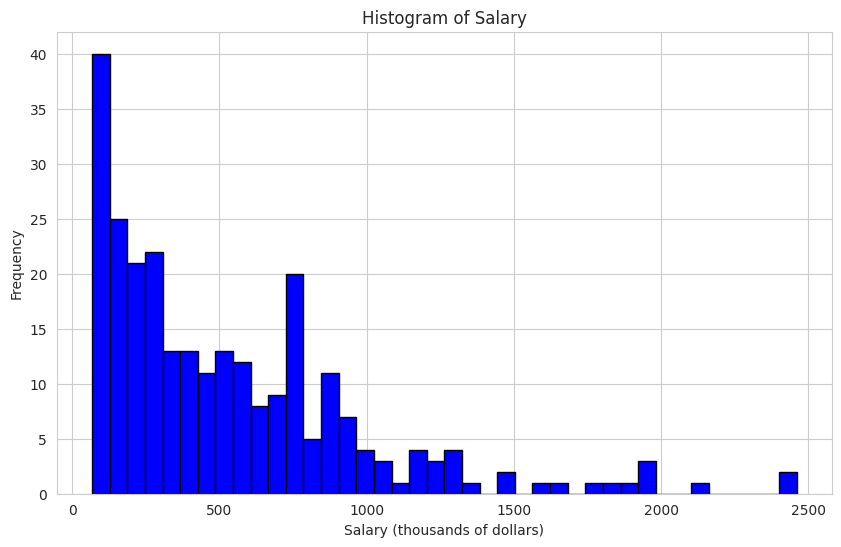

In [12]:
plt.figure(figsize=(10, 6))                                # create new figure with specified size
                                                           # figsize takes (width, height) in inches
plt.hist(hitters['Salary'].dropna(), bins=40, color='blue', edgecolor='black')
                                                           # plt.hist() creates histogram
                                                           # .dropna() removes missing values
                                                           # bins=40 divides data into 40 intervals
                                                           # color sets fill color
                                                           # edgecolor sets border color
plt.xlabel('Salary (thousands of dollars)')               # set x-axis label
plt.ylabel('Frequency')                                    # set y-axis label
plt.title('Histogram of Salary')                          # set plot title
plt.show()                                                 # display the plot

The `plt.figure()` function creates a new figure object with dimensions specified in inches. The `plt.hist()` function computes and plots a histogram, which divides the data range into bins and counts how many observations fall into each bin. The `.dropna()` method removes missing values before plotting, since missing data would cause errors. The `bins=40` parameter divides the salary range into 40 equal-width intervals. The resulting histogram shows a strong right skew, with most players earning between $100,000 and $500,000, but a long tail extending to salaries above $2,000,000. This skewed distribution suggests that a log transformation might be appropriate to stabilize variance and improve model fit.

## Display Players with Missing Salary

Let's examine which players are missing salary data.

In [13]:
missing_salary = hitters[hitters['Salary'].isnull()].index.tolist()
# hitters['Salary'].isnull() creates boolean Series
# hitters[...] filters rows where condition is True (boolean indexing)
# .index extracts row labels (player names)
# .tolist() converts Index to list

print("First 5 players with missing salary:")             # label output
print(missing_salary[:5])                                 # slice first 5 elements from list

First 5 players with missing salary:
[293, 183, 407, 22, 313]


This code demonstrates boolean indexing, a powerful pandas feature. The expression `hitters['Salary'].isnull()` creates a boolean Series with `True` for missing salaries and `False` for present salaries. When we pass this boolean Series to `hitters[...]`, pandas returns a new DataFrame containing only the rows where the condition is `True`. The `.index` attribute extracts the row labels (player names) from this filtered DataFrame. Finally, `.tolist()` converts the pandas Index to a standard Python list, and we slice the first 5 elements using list indexing `[:5]`. We might ask: do these players with missing salaries have something in common, or is the data missing at random? If possible, we could search for their actual salaries online to fill in the missing values.

## Handle Missing Data

For simplicity, we will remove players with missing Salary. However, this is not usually a good idea. As data scientists, we must think carefully about why data is missing. The missing data mechanism matters: is it missing completely at random (MCAR), missing at random (MAR), or missing not at random (MNAR)? The answer affects whether simple deletion is valid or introduces bias.

In [14]:
data_comp = hitters.dropna()  # .dropna() removes all rows with any missing values
                              # returns new DataFrame (doesn't modify original)
                              # "comp" stands for "complete cases"

print(f"Kept {len(data_comp)} players out of {len(hitters)}")
# len() returns number of rows in DataFrame
# f"..." formats the counts into readable message

Kept 263 players out of 322


The `.dropna()` method removes all rows containing any missing values, returning a new DataFrame. By default, it checks all columns and removes a row if any column has a missing value. Since only the Salary column has missing data, this effectively removes the 59 players with unknown salaries. The original DataFrame `hitters` remains unchanged because pandas operations typically return new objects rather than modifying in place. The `len()` function returns the number of rows in a DataFrame. We retained 263 players out of the original 322, meaning we lost approximately 18% of our data. This substantial loss should concern us—we should investigate whether these 59 players differ systematically from those with salary data.

## Verify Cleaned Data Dimensions

In [15]:
print(f"Dimensions: {data_comp.shape}")  # .shape returns (rows, columns) tuple
                                         # 263 rows (players), 20 columns (variables)

Dimensions: (263, 19)


After removing missing values, our cleaned dataset `data_comp` contains 263 rows and 20 columns. The number of columns remains the same because we only removed rows, not variables. This DataFrame now contains complete data for all 20 variables across all 263 players, allowing us to proceed with visualization and modeling without concerns about missing value handling.

## 2.2 Data Visualization

### 2.2.1 Pairwise Scatter Plots

Let's examine relationships among variables using pairwise scatter plots. We'll focus on a subset of variables to keep the visualization manageable.

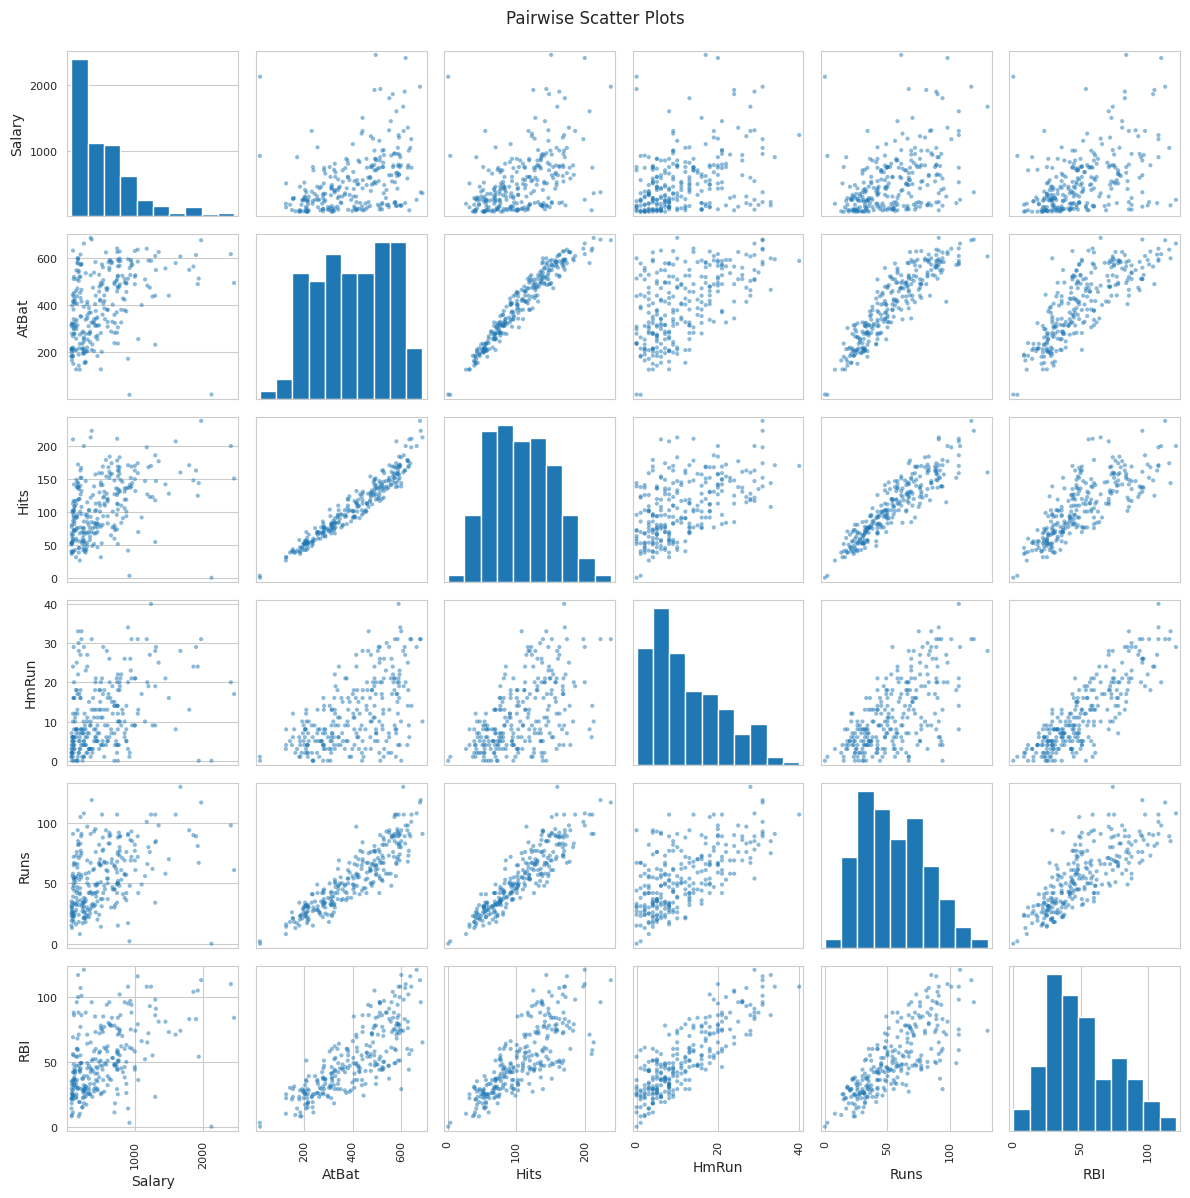

In [17]:
from pandas.plotting import scatter_matrix              # import scatter_matrix function

numeric_cols = ['Salary', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI']
# list of column names to include
# square brackets [] create Python list
# strings in quotes are column names

data_comp = data_comp.reset_index() # Reset the index so 'AtBat' becomes a column

subset_data = data_comp[numeric_cols]                   # select columns by passing list to []
                                                        # creates new DataFrame with 6 columns

fig, ax = plt.subplots(figsize=(12, 12))                # create figure and axes objects
                                                        # figsize=(12,12) makes large square plot
                                                        # returns tuple: fig (figure), ax (axes)

scatter_matrix(subset_data, alpha=0.5, diagonal='hist', ax=ax)
# scatter_matrix() creates grid of scatter plots
# alpha=0.5 makes points 50% transparent (helps see overlap)
# diagonal='hist' puts histograms on diagonal instead of scatter
# ax=ax specifies which axes to draw on

plt.suptitle('Pairwise Scatter Plots', y=0.995)         # add overall title
                                                        # y=0.995 positions title at top
plt.tight_layout()                                      # adjust spacing to prevent overlap
plt.show()                                              # display the plot

The `scatter_matrix()` function creates a grid of plots where each cell shows the relationship between two variables. The diagonal cells contain histograms showing the distribution of each individual variable. The off-diagonal cells contain scatter plots: the cell in row $i$ and column $j$ shows variable $i$ on the y-axis versus variable $j$ on the x-axis. The `alpha=0.5` parameter sets transparency to 50%, making it easier to see where many points overlap (darker regions indicate more overlap). The resulting visualization allows us to quickly examine all pairwise relationships simultaneously. We can look for linear trends in the scatter plots and assess the distribution shape from the histograms. For example, the scatter plots reveal positive relationships between Salary and most performance metrics, with CHits and CRBI showing particularly strong associations.

### 2.2.2 Correlation Tables

Let's compute and examine the pairwise correlations among all numeric variables. Correlation measures the strength and direction of linear relationships between variables, ranging from $-1$ (perfect negative linear relationship) to $+1$ (perfect positive linear relationship), with $0$ indicating no linear relationship.

In [18]:
numeric_data = data_comp.select_dtypes(include=[np.number])
# .select_dtypes() filters columns by data type
# include=[np.number] keeps only numeric columns
# excludes object types (League, Division, NewLeague)

correlation_matrix = numeric_data.corr()                # .corr() computes pairwise Pearson correlations
                                                        # returns DataFrame with correlations
                                                        # diagonal is 1.0 (variable correlated with itself)

print(correlation_matrix)                               # display full correlation matrix

            AtBat      Hits     HmRun      Runs       RBI     Walks     Years  \
AtBat    1.000000  0.963969  0.555102  0.899829  0.796015  0.624448  0.012725   
Hits     0.963969  1.000000  0.530627  0.910630  0.788478  0.587311  0.018598   
HmRun    0.555102  0.530627  1.000000  0.631076  0.849107  0.440454  0.113488   
Runs     0.899829  0.910630  0.631076  1.000000  0.778692  0.697015 -0.011975   
RBI      0.796015  0.788478  0.849107  0.778692  1.000000  0.569505  0.129668   
Walks    0.624448  0.587311  0.440454  0.697015  0.569505  1.000000  0.134793   
Years    0.012725  0.018598  0.113488 -0.011975  0.129668  0.134793  1.000000   
CAtBat   0.207166  0.206678  0.217464  0.171811  0.278126  0.269450  0.915681   
CHits    0.225341  0.235606  0.217496  0.191327  0.292137  0.270795  0.897844   
CHmRun   0.212422  0.189364  0.492526  0.229701  0.442190  0.349582  0.722371   
CRuns    0.237278  0.238896  0.258347  0.237831  0.307226  0.332977  0.876649   
CRBI     0.221393  0.219384 

The `.select_dtypes(include=[np.number])` method filters the DataFrame to keep only columns with numeric data types (int64, float64), excluding the three categorical variables stored as object type. The `.corr()` method computes Pearson correlation coefficients for all pairs of numeric columns. The Pearson correlation between variables $X$ and $Y$ is defined as:

$$r_{XY} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$$

This measures the strength of the linear relationship between two variables. The result is a symmetric matrix where element $(i,j)$ contains the correlation between variable $i$ and variable $j$. The diagonal elements equal 1 because each variable is perfectly correlated with itself. Looking at the Salary row/column, we can identify which performance metrics have the strongest linear associations with salary.

### 2.2.3 Correlation Heatmap

We can visualize the correlation matrix using a heatmap, where color intensity represents correlation strength.

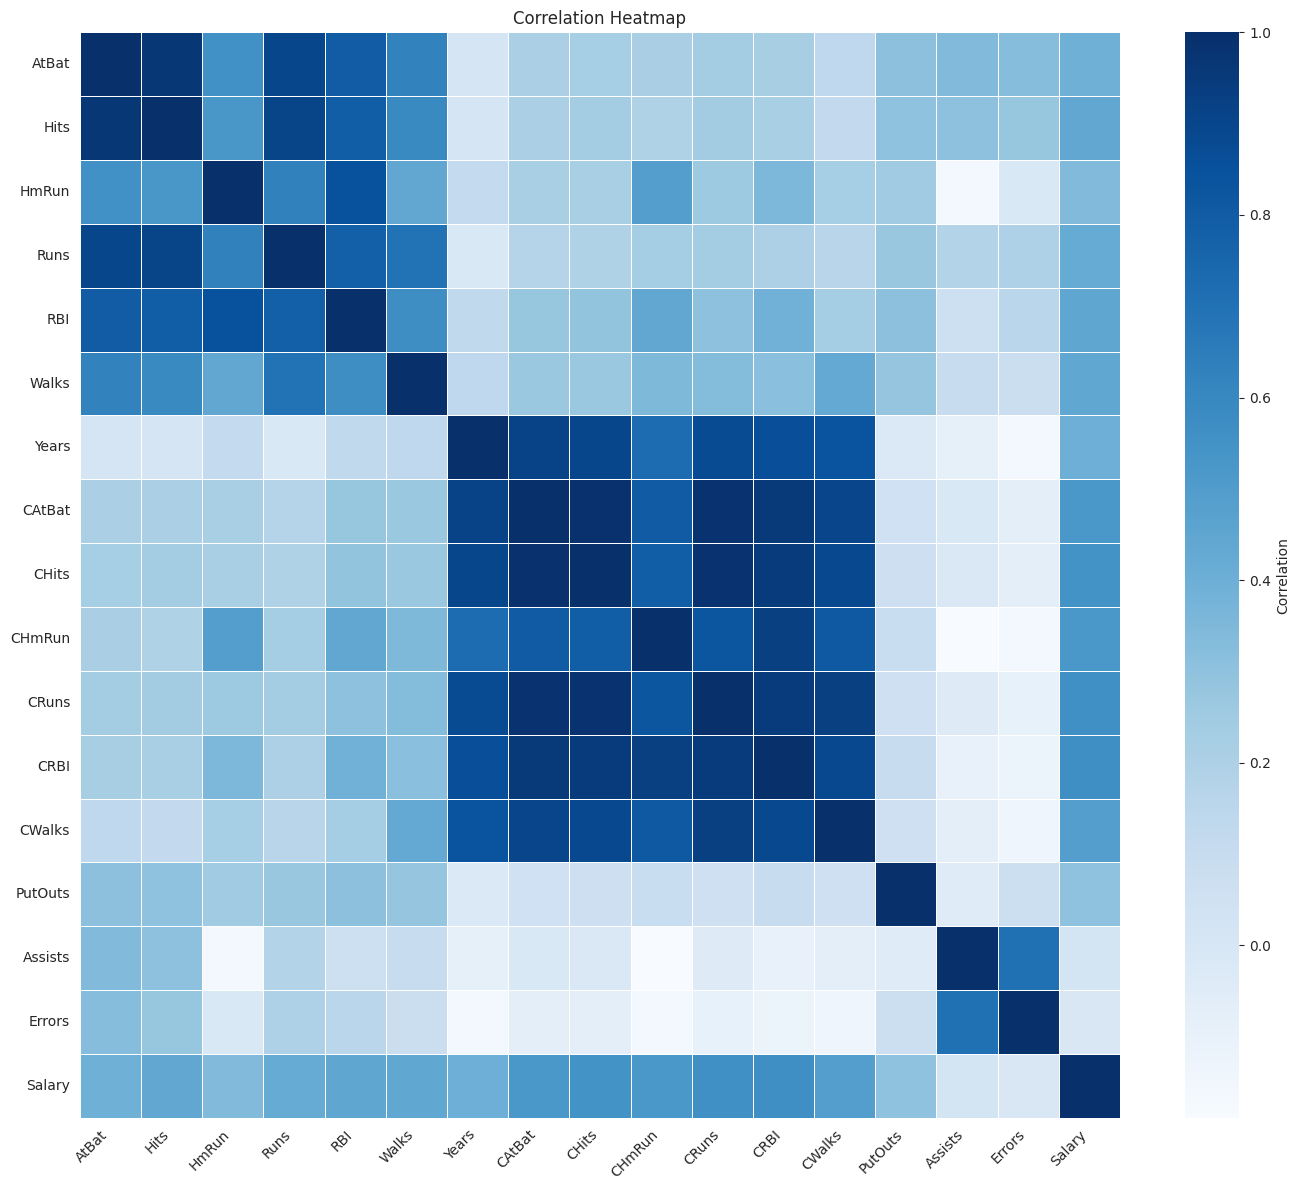

In [19]:
plt.figure(figsize=(14, 12))                            # create large figure
sns.heatmap(correlation_matrix,                         # sns.heatmap() creates colored grid
            annot=False,                                # annot=False omits numbers in cells
            cmap='Blues',                               # cmap='Blues' uses blue color scheme
            linewidths=0.5,                             # linewidths=0.5 draws thin grid lines
            cbar_kws={'label': 'Correlation'})          # cbar_kws passes dict to colorbar
                                                        # sets colorbar label
plt.title('Correlation Heatmap')                        # add title
plt.xticks(rotation=45, ha='right')                     # rotate x-axis labels 45 degrees
                                                        # ha='right' aligns labels right
plt.yticks(rotation=0)                                  # keep y-axis labels horizontal
plt.tight_layout()                                      # adjust layout to prevent cutoff
plt.show()                                              # display plot

The `sns.heatmap()` function creates a color-coded matrix where color intensity represents the magnitude of correlation. The `cmap='Blues'` parameter uses a color scheme ranging from light blue (low correlation) to dark blue (high correlation). The `annot=False` setting omits the numeric correlation values from each cell, making the visualization cleaner when we have many variables. The `linewidths=0.5` parameter draws thin white lines between cells to visually separate them. We rotate the x-axis labels 45 degrees using `plt.xticks(rotation=45)` to prevent overlap, and the `ha='right'` parameter aligns the rotated labels to the right for better positioning. This visualization allows us to quickly identify clusters of highly correlated variables by looking for dark blue regions. We observe that career statistics (CAtBat, CHits, CHmRun, CRuns, CRBI, CWalks) are all highly correlated with each other and moderately correlated with Salary.

### Reorder Correlation Heatmap by Salary

We can reorder the variables by their absolute correlation with Salary to better visualize which predictors are most strongly related to our response variable.

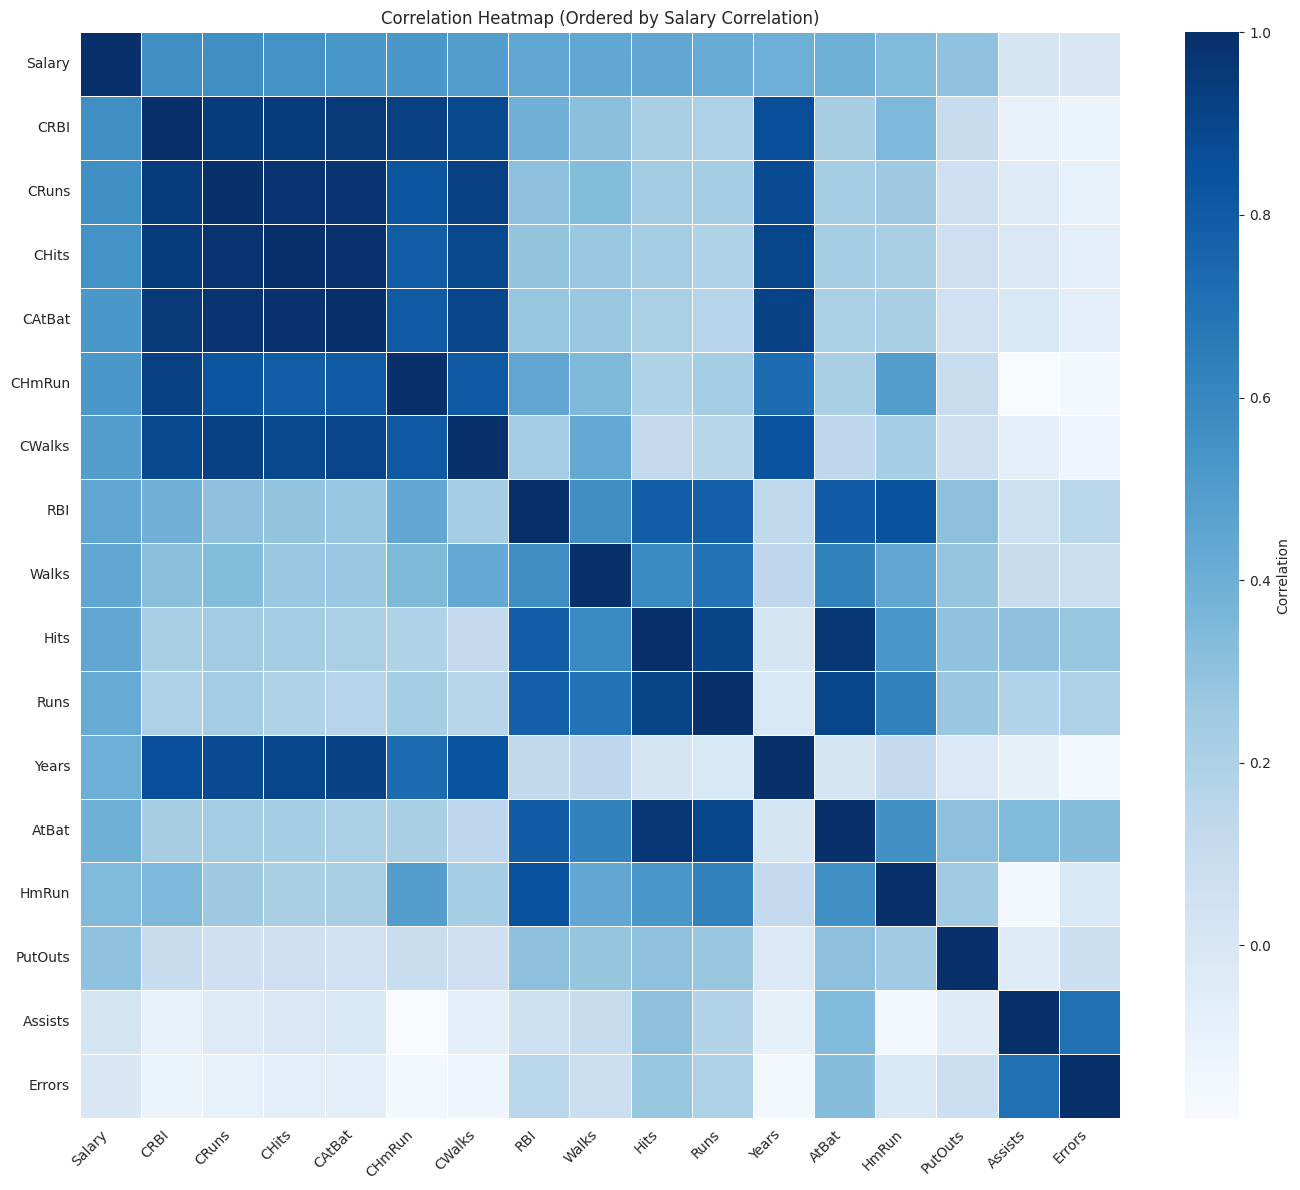

In [20]:
salary_corr = correlation_matrix['Salary'].abs().sort_values(ascending=False)
# correlation_matrix['Salary'] extracts Salary column (Series)
# .abs() takes absolute value of each correlation
# .sort_values(ascending=False) sorts from largest to smallest
# result is Series with variables ordered by |correlation with Salary|

ordered_cols = salary_corr.index.tolist()               # .index gets variable names in sorted order
                                                        # .tolist() converts Index to list

ordered_corr = correlation_matrix.loc[ordered_cols, ordered_cols]
# .loc[rows, cols] indexes DataFrame by labels
# reorders both rows and columns to match ordered_cols
# creates new matrix with same variables but reordered

plt.figure(figsize=(14, 12))                            # create large figure
sns.heatmap(ordered_corr,                               # plot reordered correlation matrix
            annot=False,                                # no numbers in cells
            cmap='Blues',                               # blue color scheme
            linewidths=0.5,                             # thin grid lines
            cbar_kws={'label': 'Correlation'})          # colorbar label
plt.title('Correlation Heatmap (Ordered by Salary Correlation)')  # descriptive title
plt.xticks(rotation=45, ha='right')                     # rotate x labels
plt.yticks(rotation=0)                                  # horizontal y labels
plt.tight_layout()                                      # adjust layout
plt.show()                                              # display

This code reorders both the rows and columns of the correlation matrix to place variables with the strongest relationship to Salary first. We extract the Salary column, take absolute values (since both strong positive and strong negative correlations are informative), and sort in descending order. The `.index` attribute of the sorted Series gives us the variable names in order of decreasing absolute correlation with Salary. We then use `.loc[ordered_cols, ordered_cols]` to reorder both dimensions of the correlation matrix simultaneously. The resulting heatmap has Salary in the top-left corner, followed by variables ordered by their strength of association with Salary. This makes it easy to see that CRBI, CRuns, and CHits have the strongest correlations with Salary (appearing in the top-left region with dark blue colors). We can also easily identify groups of highly intercorrelated predictors by looking for dark blue off-diagonal blocks.

### 2.2.4 Transformations on Variables

We mainly care about percentage changes in salary, so we will apply a log transformation to Salary. The difference in log salary is approximately equivalent to percentage changes in salary because for small changes:

$$\log(Y_{new}) - \log(Y_{old}) = \log\left(\frac{Y_{new}}{Y_{old}}\right) \approx \frac{Y_{new} - Y_{old}}{Y_{old}}$$

This last expression is the percentage change in $Y$.

## Transform Salary to Log Scale

In [21]:
data1 = data_comp.copy()                                # .copy() creates independent duplicate
                                                        # prevents modifications from affecting original
data1['LogSalary'] = np.log(data1['Salary'])           # np.log() computes natural logarithm
                                                        # creates new column called 'LogSalary'
                                                        # uses bracket notation to add column
data1 = data1.drop(columns=['Salary'])                 # .drop() removes specified columns
                                                        # columns=['Salary'] specifies what to drop
                                                        # returns new DataFrame

print(data1.columns.tolist())                          # display new column names

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague', 'LogSalary']


The `.copy()` method creates a deep copy of the DataFrame, ensuring that subsequent modifications to `data1` do not affect the original `data_comp`. The `np.log()` function computes the natural logarithm (base $e$) of each salary value. We use bracket notation `data1['LogSalary']` to create a new column, and pandas automatically aligns the values with the existing rows. The `.drop(columns=['Salary'])` method removes the original Salary column, returning a new DataFrame. We save this result back to `data1`, effectively replacing the DataFrame with a version that has LogSalary instead of Salary. The natural logarithm transformation has several benefits: it reduces right skewness in the distribution, stabilizes variance (making it more constant across the range of predicted values), and allows us to interpret regression coefficients as approximate percentage effects.

## Compare Residual Plots: Original vs Log-Transformed Salary

Let's fit simple linear models and examine residual plots to see whether the log transformation improves the model assumptions.

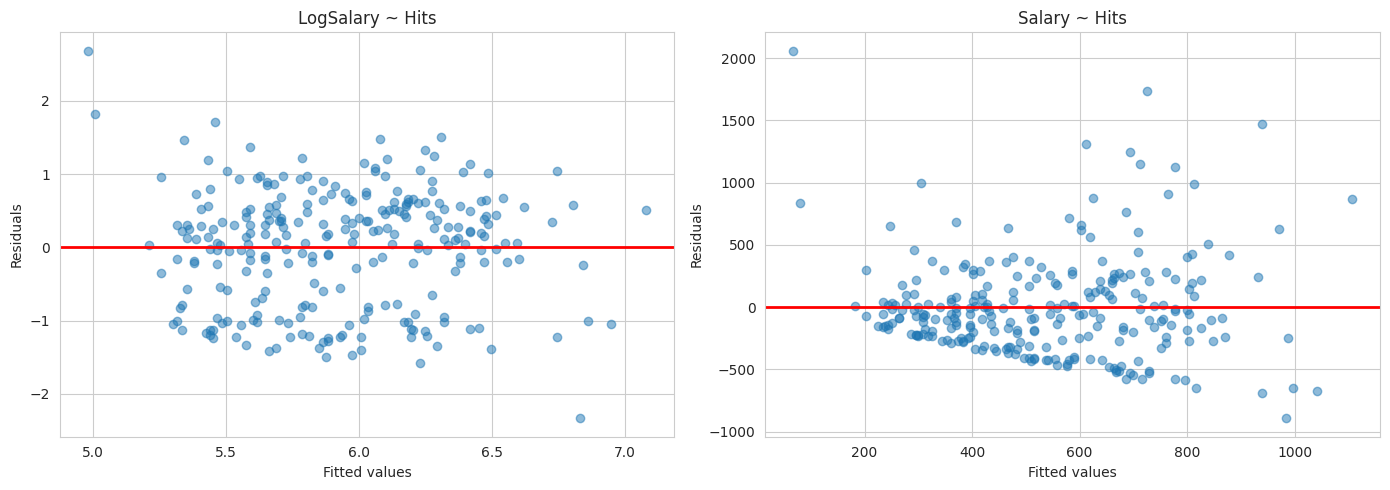

In [22]:
fit_log = smf.ols('LogSalary ~ Hits', data=data1).fit()
# smf.ols() creates ordinary least squares model using formula
# 'LogSalary ~ Hits' specifies response ~ predictor
# ~ separates response (left) from predictors (right)
# data=data1 tells it which DataFrame contains these variables
# .fit() estimates coefficients using least squares

fit_original = smf.ols('Salary ~ Hits', data=data_comp).fit()
# same but with untransformed Salary
# uses data_comp which still has original Salary

fig, axes = plt.subplots(1, 2, figsize=(14, 5))         # create 1 row, 2 columns of plots
                                                        # returns fig (figure) and axes (array of 2 axes)

axes[0].scatter(fit_log.fittedvalues, fit_log.resid, alpha=0.5)
# axes[0] is first subplot
# .scatter() creates scatter plot
# .fittedvalues are predicted values (ŷᵢ)
# .resid are residuals (yᵢ - ŷᵢ)
# alpha=0.5 makes points semi-transparent

axes[0].axhline(y=0, color='red', linewidth=2)          # .axhline() draws horizontal line
                                                        # y=0 specifies height
                                                        # color='red', linewidth=2 for visibility

axes[0].set_xlabel('Fitted values')                     # label x-axis
axes[0].set_ylabel('Residuals')                         # label y-axis
axes[0].set_title('LogSalary ~ Hits')                   # title for first subplot

axes[1].scatter(fit_original.fittedvalues, fit_original.resid, alpha=0.5)
# same process for second subplot (untransformed)
axes[1].axhline(y=0, color='red', linewidth=2)
axes[1].set_xlabel('Fitted values')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Salary ~ Hits')

plt.tight_layout()                                      # adjust spacing between subplots
plt.show()                                              # display both plots

The `smf.ols()` function creates a linear regression model using R-style formula syntax. The formula `'LogSalary ~ Hits'` specifies that LogSalary is the response variable and Hits is the predictor. The `~` symbol separates the left-hand side (response) from the right-hand side (predictors). The `.fit()` method estimates the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$ using ordinary least squares. After fitting, the model object has several useful attributes: `.fittedvalues` contains the predicted values $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i$ for each observation, and `.resid` contains the residuals $e_i = y_i - \hat{y}_i$. We create side-by-side residual plots to compare the two models. A good regression model should have residuals that are randomly scattered around zero with constant variance (homoscedasticity). The plot on the left (LogSalary) shows more constant spread across the range of fitted values, while the plot on the right (untransformed Salary) shows increasing spread as fitted values increase (heteroscedasticity), indicating that the log transformation better satisfies the regression assumptions.

## Save Cleaned and Transformed Data

Let's save our working dataset to a CSV file for future use.

In [23]:
data1.to_csv("Hitters_comp.csv")                        # .to_csv() writes DataFrame to CSV file
                                                        # filename specified as string
                                                        # includes index (player names) by default
print("Data saved to Hitters_comp.csv")                 # confirmation message

Data saved to Hitters_comp.csv


The `.to_csv()` method writes a DataFrame to a comma-separated values file. By default, it includes the index (player names in our case) as the first column. The file is saved in the current working directory. This allows us to reload the cleaned, transformed dataset in future sessions without repeating the data cleaning and transformation steps. The saved file will contain 263 rows (players) and 20 columns (19 predictors plus LogSalary).

# 3. Model Selection

Let's reload our cleaned dataset to begin the model selection process.

In [24]:
data1 = pd.read_csv("Hitters_comp.csv", index_col=0)    # reload cleaned data
                                                        # index_col=0 uses first column as index
print(data1.columns.tolist())                          # verify columns

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague', 'LogSalary']


We reload the saved dataset to ensure we're starting with a clean slate. This is good practice in data analysis workflows, as it makes the analysis more reproducible. The dataset now contains LogSalary instead of Salary, and all 263 players have complete data.

We do not do model selection if we can avoid it. For example, if there is solid science behind a model, we may only need to estimate unknown parameters. Often we do not have theory behind the relationship between response and predictors, so we must rely on data to choose a model.

Given a set of $p$ predictors, there will be $2^p$ possible models (in this case $2^{19} = 524{,}288$ models). Which model should we use?

**Goal:** Build a parsimonious (simple) model which predicts the response as "accurately" as possible.

## 3.1 Criteria of Accuracy

Given a model with $d$ predictors, can we use $MSE$ (mean squared error) or mean residual sum of squares as a criterion? That is, choose a model with smallest $RSS$ or highest $R^2$? If so, the best model would always be the model with all 19 variables. Why is this problematic?

On the other hand, a model with all variables may not be the best one. Let us run the full model.

## Fit the Full Model

In [25]:
fit_all = smf.ols('LogSalary ~ AtBat + Hits + HmRun + Runs + RBI + Walks + Years + CAtBat + CHits + CHmRun + CRuns + CRBI + CWalks + League + Division + PutOuts + Assists + Errors + NewLeague',
                  data=data1).fit()                     # formula with all 19 predictors
                                                        # + symbol adds predictors
                                                        # categorical variables automatically converted to dummies
print(fit_all.summary())                                # .summary() displays full regression output

                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     16.18
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           3.23e-33
Time:                        13:45:55   Log-Likelihood:                -234.26
No. Observations:                 263   AIC:                             508.5
Df Residuals:                     243   BIC:                             580.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.6181      0.176     26.

The formula includes all 19 predictor variables separated by `+` symbols. The categorical variables (League, Division, NewLeague) are automatically converted to dummy variables by statsmodels. For example, League has two levels (A and N), so statsmodels creates one dummy variable (League[T.N]) that equals 1 for National League and 0 for American League. The `.summary()` method displays comprehensive regression output including coefficient estimates, standard errors, t-statistics, p-values, $R^2$, adjusted $R^2$, and diagnostic statistics. We observe that the full model achieves $R^2 = 0.559$, meaning it explains about 56% of the variation in log salary. However, many predictors have large p-values, suggesting they may not be statistically significant.

### Remarks

- It is hard to interpret the model due to multicollinearity (predictors are highly correlated with each other)
- However, we can still use this model for prediction
- Would the model with all predictors whose p-value < 0.05 be the "best" one?

**Answer:** Not necessarily!

We will introduce several commonly used statistics to assess accuracy of a model with $d$ predictors.

### 3.1.1 Mean Squared Error (MSE)

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \frac{RSS}{n}$$

where $RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$ is the residual sum of squares, $y_i$ are observed values, and $\hat{y}_i$ are fitted values.

Notice that the MSE above is the **TRAINING ERROR**. We use the same data to build our linear model and then we use exactly the same data to evaluate the discrepancy between observed and fitted responses.

MSE is simple but it does not evaluate model accuracy for unseen data. One way out is to have another dataset (Testing Data) that we haven't touched yet, which we could use to calculate the testing MSE—a much better estimate of prediction error.

### 3.1.2 Prediction Error

By prediction error we mean the expected MSE for future observations. Take future $n$ pairs of observations $(x_1, y_1^*), \ldots, (x_n, y_n^*)$:

$$\text{Prediction Error} = E\left[\frac{1}{n}\sum_{i=1}^{n}(y_i^* - \hat{y}_{x_i})^2\right]$$

This is the mean prediction error for all the $x_i$'s in our data. This is a theoretical quantity. We need to estimate it using our training data through a mathematical formula or through a reserved testing dataset.

### 3.1.3 Mallows's $C_p$

Through mathematics, by modifying $RSS$ with the training data, we introduce the famous Mallows' $C_p$ statistic:

$$C_p = \frac{1}{n}(RSS + 2d \cdot \hat{\sigma}^2)$$

**Note:**
- $d$: Number of predictors in the model (not including intercept)
- $\hat{\sigma}^2$: Mean Squared Error (MSE) from the **full model**

**Fact:** If the full model is true, $C_p$ is an unbiased estimator of average prediction errors, namely $\frac{1}{n}\sum_{i=1}^{n}E[(y_i|x_i - \hat{y}_i)^2]$ (differing by some fixed quantity).

**Important properties:**
- $C_p$ values might be defined slightly differently across software, but this will not affect the final model chosen
- $C_p$ will not always be decreasing as a function of $d$! (Unlike $RSS$)
- We choose a model with smallest (or nearly smallest) $C_p$

**Remarks:**
- The variability of $C_p$ is large
- The validity of $C_p$ is restricted to situations where the full linear model is true
- $C_p$ works only for fixed design, meaning the predictors $x$'s are not treated as random. But if the data is observational (which happens often), we should really treat predictors as random as well.

### 3.1.4 Akaike Information Criterion (AIC)

$$AIC = 2k - 2\ln(\hat{L})$$

where:
- $k$: Number of estimated parameters
- $\hat{L}$: Maximum value of the likelihood function for the model

AIC is equivalent to $C_p$ in the regression setup. The likelihood function measures how probable the observed data is under the model (to be discussed in logistic regression).

### 3.1.5 Bayesian Information Criterion (BIC)

BIC is formally defined as:

$$BIC = k\ln(n) - 2\ln(\hat{L})$$

An alternative form for linear regression is:

$$BIC = \frac{1}{n}(RSS + k \cdot \ln(n) \cdot \hat{\sigma}^2)$$

where:
- $k$: Number of free parameters in the model (including intercept)
- $n$: Number of observations
- $\hat{\sigma}^2$: Error variance estimate from full model

**Properties:**
- $BIC$ is derived from a Bayesian framework
- BIC calculates the probability of the model after seeing the data, when assigning equal probability to each model
- It tends to select smaller models than $C_p$ or AIC
- The penalty term $k \cdot \ln(n)$ grows faster than $2k$, especially when $n$ is large

### 3.1.6 Testing Errors

If we have a testing dataset that was never used in model building, we can compute testing errors as:

$$\text{Test Error} = \sum_{i=1}^{n_{test}}(y_{test,i} - \hat{y}_{x_{test,i}})^2$$

where the sum is over the testing observations, $y_{test,i}$ are the actual responses in the test set, and $\hat{y}_{x_{test,i}}$ are predictions from our model evaluated at test set predictor values.

This provides an honest assessment of prediction accuracy because the test data played no role in model selection or coefficient estimation.

# 4. Model Building

In this lecture we concentrate on using $C_p$ as a criterion to find a good model with small prediction errors. We will implement forward stepwise selection, which is computationally tractable even when the number of predictors is large.

## 4.1 Forward Stepwise Selection with $C_p$

**Algorithm:**
1. Start with the null model (intercept only)
2. For each predictor not in the model, tentatively add it and compute $C_p$
3. Add the predictor that gives the best (lowest) $C_p$
4. Repeat steps 2-3 until $C_p$ stops improving or we reach the maximum model size

**The $C_p$ criterion:**

$$C_p = \frac{1}{n}(RSS + 2d \cdot \hat{\sigma}^2)$$

where:
- $RSS$ = residual sum of squares for the current model
- $d$ = number of predictors (not including intercept)
- $\hat{\sigma}^2$ = MSE from the full model
- $n$ = number of observations

**Why $C_p$ works:** The $RSS$ term measures model fit (lower is better), while the $2d\hat{\sigma}^2$ term penalizes complexity. Unlike $RSS$ alone, which always decreases when adding predictors, $C_p$ balances fit against overfitting.

## Prepare Data for Model Selection

We begin by extracting the response variable and predictor variables from our DataFrame.

In [26]:
y = data1['LogSalary']                                  # extract response column
                                                        # returns pandas Series
Y = np.array(y)                                         # convert Series to numpy array
                                                        # np.array() creates ndarray object

X_predictors = data1.drop(columns=['LogSalary'])        # remove response column
                                                        # .drop() returns new DataFrame
                                                        # contains only predictor variables

print(f"Response variable: LogSalary")                  # display info
print(f"Number of observations: {len(Y)}")              # len() gives array length
print(f"Number of predictor columns: {X_predictors.shape[1]}")
# .shape[1] gives number of columns
print(f"\nPredictor columns:")
print(X_predictors.columns.tolist())                    # list all predictor names

Response variable: LogSalary
Number of observations: 263
Number of predictor columns: 19

Predictor columns:
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']


We extract the LogSalary column as a pandas Series using bracket notation, then convert it to a numpy array with `np.array()`. A numpy array is required by the statsmodels OLS function. The `.drop(columns=['LogSalary'])` method removes the response variable, leaving a DataFrame containing only the 19 predictor variables. We confirm we have 263 observations and 19 predictor columns. Note that three of these columns (League, Division, NewLeague) are categorical and will need to be converted to dummy variables.

## Create Dummy Variables for Categorical Predictors

Our categorical variables contain string values ('A', 'N', 'E', 'W'), but regression requires numeric input. We must convert these to dummy (indicator) variables.

**Dummy Variable Encoding:** For a categorical variable with $k$ levels, we create $k-1$ binary (0/1) indicator variables. The omitted level becomes the "reference category." For example:
- Division has 2 levels: 'E' (East) and 'W' (West)
- We create 1 dummy: Division_W
- Division_W = 1 if West, Division_W = 0 if East (reference)

**Why $k-1$ instead of $k$ dummies?** Creating all $k$ dummies would cause perfect multicollinearity (the dummy variable trap). If we created both Division_E and Division_W, they would sum to 1 always: Division_E + Division_W = 1. This makes the design matrix singular (non-invertible), preventing OLS estimation.

In [27]:
X_dummies = pd.get_dummies(X_predictors, drop_first=True)
# pd.get_dummies() converts categorical to dummy variables
# automatically detects object/category columns
# creates new column for each category level
# drop_first=True removes first category (avoids multicollinearity)
# numeric columns pass through unchanged

print(f"Original number of columns: {X_predictors.shape[1]}")
# count columns before encoding
print(f"After dummy encoding: {X_dummies.shape[1]}")
# count columns after encoding (should be same)
print(f"\nOriginal columns:")
print(X_predictors.columns.tolist())
print(f"\nColumns after dummy encoding:")
print(X_dummies.columns.tolist())                       # show new column names

Original number of columns: 19
After dummy encoding: 19

Original columns:
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague']

Columns after dummy encoding:
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']


The `pd.get_dummies()` function automatically identifies categorical columns (those with object or category dtype) and converts each to dummy variables. The `drop_first=True` parameter removes the first category level from each categorical variable to avoid the dummy variable trap. For our three categorical variables, this creates three dummy variables: League_N (1 if National League), Division_W (1 if West Division), and NewLeague_N (1 if National League). The numeric columns (AtBat, Hits, etc.) pass through unchanged. The total remains 19 columns: 16 numeric variables plus 3 dummy variables. The suffix notation indicates which category is represented: League_N = 1 means National League (American League is the reference), Division_W = 1 means West Division (East is the reference), and NewLeague_N = 1 means National League (American is the reference).

## Create ModelSpec Object

The ModelSpec from ISLP serves as a specification for building design matrices in regression models. It defines which predictors to include and how to transform them.

In [29]:
from ISLP.models import ModelSpec as MS                 # Import ModelSpec and alias as MS

design = MS(X_dummies.columns).fit(X_dummies)
# MS() is ModelSpec constructor
# takes column names as input (pandas Index)
# creates "recipe" for building design matrices
# .fit() method inspects the data
# determines how to transform each column
# stores transformation information in design object

print(f"ModelSpec created")
print(f"Number of terms: {len(design.terms)}")          # len() counts terms
                                                        # design.terms is list of predictor names
print(f"Terms: {design.terms}")                         # display predictor names

X_design = design.transform(X_dummies)                  # .transform() applies ModelSpec to data
                                                        # adds intercept column automatically
                                                        # returns pandas DataFrame

print(f"\nDesign matrix shape: {X_design.shape}")      # (rows, columns) tuple
print(f"Design matrix columns: {X_design.columns.tolist()}")
# show all column names including intercept

ModelSpec created
Number of terms: 19
Terms: Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors', 'League_N', 'Division_W', 'NewLeague_N'],
      dtype='object')

Design matrix shape: (263, 20)
Design matrix columns: ['intercept', 'AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']


The `MS()` constructor creates a ModelSpec object that defines how to build a design matrix. We pass it the column names from our dummy-encoded DataFrame. The `.fit()` method examines the actual data to determine appropriate transformations. The `.transform()` method then applies the specification to create the design matrix. Critically, ModelSpec automatically adds an intercept column (a column of all 1's) to the design matrix. This is why `X_design.shape` shows 20 columns instead of 19—the additional column is the intercept. In matrix notation, our regression model is:

$$Y = X\beta + \epsilon$$

where $X$ is the $(263 \times 20)$ design matrix (including intercept), $\beta$ is the $(20 \times 1)$ vector of coefficients (including intercept), and $\epsilon$ is the $(263 \times 1)$ vector of errors.

## Estimate $\hat{\sigma}^2$ from Full Model

We must estimate $\sigma^2$, the error variance, by fitting the full model containing all 19 predictors. This quantity appears in the $C_p$ formula:

$$C_p = \frac{1}{n}(RSS + 2d \cdot \hat{\sigma}^2)$$

where $\hat{\sigma}^2$ is computed from the full model as:

$$\hat{\sigma}^2 = \frac{RSS_{full}}{n - p} = \frac{1}{n-p}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

with $n = 263$ observations and $p = 20$ parameters (19 predictors plus intercept).

In [30]:
X_full = X_design.values.astype(float)                  # .values extracts numpy array from DataFrame
                                                        # .astype(float) ensures float64 dtype
                                                        # prevents dtype issues with statsmodels

full_model = OLS(Y, X_full).fit()                       # OLS(endog, exog) creates OLS object
                                                        # Y is response (endogenous variable)
                                                        # X_full is design matrix (exogenous variables)
                                                        # .fit() computes β̂ = (X'X)^(-1)X'Y

sigma2_full = full_model.scale                          # .scale attribute contains MSE
                                                        # MSE = RSS / (n - p)
                                                        # this is our estimate of σ²

print(f"Full Model Results:")
print(f"{'='*60}")
print(f"Sigma-squared (MSE from full model): {sigma2_full:.6f}")
# :.6f formats to 6 decimal places
print(f"Number of parameters: {len(full_model.params)}")
# len() counts coefficients
print(f"R-squared: {full_model.rsquared:.4f}")          # .rsquared is R²
print(f"Adjusted R-squared: {full_model.rsquared_adj:.4f}")
# .rsquared_adj adjusts for number of predictors
print(f"Residual standard error: {np.sqrt(sigma2_full):.4f}")
# np.sqrt() computes square root

Full Model Results:
Sigma-squared (MSE from full model): 0.376322
Number of parameters: 20
R-squared: 0.5586
Adjusted R-squared: 0.5240
Residual standard error: 0.6135


The `OLS(Y, X_full)` constructor creates an ordinary least squares regression object. The first argument is the response variable (also called the endogenous variable), and the second argument is the design matrix (also called the exogenous variables). The `.fit()` method computes the OLS coefficient estimates using the closed-form solution $\hat{\beta} = (X'X)^{-1}X'Y$. The `.scale` attribute contains the mean squared error, computed as $\hat{\sigma}^2 = RSS / (n-p)$ where $RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$ is the residual sum of squares, $n = 263$ is the number of observations, and $p = 20$ is the number of parameters. For our full model, $\hat{\sigma}^2 \approx 0.376$. This value will remain fixed throughout our model selection process, as it represents our best estimate of the true error variance. Every candidate model's $C_p$ will be computed using this same $\hat{\sigma}^2$.

## Define Negative $C_p$ Scoring Function

We now define our scoring function to evaluate candidate models. We return the negative $C_p$ because sklearn's model selection tools maximize scores by default, but we want to minimize $C_p$.

The $C_p$ statistic for a model with $d$ predictors is:

$$C_p = \frac{1}{n}(RSS + 2d \cdot \hat{\sigma}^2)$$

where:
- $RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$ measures model fit
- $2d\hat{\sigma}^2$ is the complexity penalty
- $n = 263$ is the sample size

In [31]:
def neg_Cp(sigma2_full, estimator, X, Y):               # def keyword defines function
                                                        # function name is neg_Cp
                                                        # parameters in parentheses
    """
    Compute negative Mallows' Cp statistic.

    Parameters:
    -----------
    sigma2_full : float
        MSE from the full model (estimate of σ²)
    estimator : fitted regression model
        Must have .predict() method returning predictions
    X : numpy array, shape (n, p)
        Design matrix with n observations and p predictors
    Y : numpy array, shape (n,)
        Response variable vector with n observations

    Returns:
    --------
    float : negative Cp value
    """
    n, p = X.shape                                      # unpack tuple into two variables
                                                        # n gets number of rows
                                                        # p gets number of columns

    Y_hat = estimator.predict(X)                        # .predict() computes ŷ = Xβ̂
                                                        # returns array of predictions

    RSS = np.sum((Y - Y_hat)**2)                        # (Y - Y_hat) computes residuals
                                                        # **2 squares each element
                                                        # np.sum() adds them up

    Cp = (RSS + 2 * p * sigma2_full) / n                # compute Cp formula
                                                        # RSS is fit, 2*p*sigma2_full is penalty
                                                        # divide by n to normalize

    return -Cp                                          # return negative (for maximization)

print("Cp scoring function defined")

Cp scoring function defined


This function computes the $C_p$ statistic for a fitted model. The `def` keyword defines a function with name `neg_Cp` and four parameters. The docstring (triple-quoted string) documents the function's purpose, parameters, and return value. Inside the function, `n, p = X.shape` unpacks the tuple returned by `.shape` into two separate variables: $n$ (number of observations) and $p$ (number of predictors including intercept). The `estimator.predict(X)` call computes predicted values $\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{i1} + \cdots + \hat{\beta}_p x_{ip}$ for each observation. The residual sum of squares is $RSS = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$, computed by squaring the residuals element-wise with `**2` and summing with `np.sum()`. The $C_p$ formula balances model fit ($RSS$ term) against complexity ($2p\hat{\sigma}^2$ term). We return $-C_p$ because sklearn's selection functions maximize scores, but we want to minimize $C_p$ (lower $C_p$ means better expected prediction error).

## Create Specialized Scoring Function

We use `partial` to create a version of our `neg_Cp` function with $\hat{\sigma}^2$ pre-filled. This adapts our function to sklearn's expected interface.

In [32]:
from functools import partial                           # import partial from functools module

neg_Cp_score = partial(neg_Cp, sigma2_full)            # partial() creates new function
                                                        # first argument to neg_Cp now fixed
                                                        # sigma2_full permanently set to 0.376
                                                        # remaining arguments must be supplied later

print("Scoring function created with frozen parameters:")
print(f"  Frozen: sigma2_full = {sigma2_full:.6f}")
print(f"  Required arguments: estimator, X, Y")
print(f"  Returns: negative Cp value (for sklearn maximization)")

Scoring function created with frozen parameters:
  Frozen: sigma2_full = 0.376322
  Required arguments: estimator, X, Y
  Returns: negative Cp value (for sklearn maximization)


The `partial` function from the functools module creates a new function by "freezing" some arguments of an existing function. The original `neg_Cp` has signature `neg_Cp(sigma2_full, estimator, X, Y)`. After applying `partial(neg_Cp, sigma2_full)`, the new function `neg_Cp_score` has signature `neg_Cp_score(estimator, X, Y)` because `sigma2_full` is permanently set to its current value of approximately 0.376. This is necessary because sklearn's model selection functions expect scoring functions with signature `scorer(estimator, X, Y)`, but our `neg_Cp` function requires an additional argument. The `partial` function adapts our interface to sklearn's requirements. Think of it as presetting one button on a remote control: the original remote has four buttons (sigma2_full, estimator, X, Y), but the new remote has only three buttons (estimator, X, Y) because sigma2_full is preset.

## Create Forward Stepwise Selection Strategy

We now create a strategy object that defines how to search through models.

In [34]:
from ISLP.models import Stepwise                         # Import Stepwise class

strategy = Stepwise.first_peak(                         # Stepwise.first_peak() is class method
                                                        # creates specific selection strategy
                                                        # "first peak" stops when score stops improving
    design,                                             # ModelSpec object with available predictors
                                                        # defines which terms can be selected
    direction='forward',                                # 'forward' starts empty, adds predictors
                                                        # 'backward' starts full, removes predictors
                                                        # 'both' can add or remove
    max_terms=len(design.terms)                         # maximum number of terms to consider
                                                        # len(design.terms) = 19
)

print("Forward stepwise selection strategy created:")
print(f"  Method: Stepwise.first_peak")
print(f"  Direction: forward (start empty, add one at a time)")
print(f"  Max terms: {len(design.terms)}")
print(f"  Stopping rule: stop when score stops improving")

Forward stepwise selection strategy created:
  Method: Stepwise.first_peak
  Direction: forward (start empty, add one at a time)
  Max terms: 19
  Stopping rule: stop when score stops improving


The `Stepwise.first_peak()` method creates a forward selection strategy. The first argument is the `design` object (our ModelSpec) that defines which predictors are available for selection. The `direction='forward'` parameter specifies forward selection: start with the null model (intercept only) and add one predictor at a time. The alternative `direction='backward'` would start with all predictors and remove them one at a time. The `max_terms` parameter limits how many predictors can be added; we set it to 19 (all available predictors). The "first peak" stopping rule means: keep adding predictors as long as the score improves, and stop when adding any remaining predictor would decrease the score. This is a greedy algorithm: at each step, it chooses the single best predictor to add without considering future consequences. It does not guarantee finding the globally optimal model, but it is computationally efficient, requiring at most $p(p+1)/2$ model fits instead of $2^p$ for exhaustive search.

## Perform Forward Selection with MSE (Default)

Let's first perform forward selection using MSE (mean squared error) as the criterion, which is sklearn's default for regression.

In [36]:
from ISLP.models import sklearn_selected # Import sklearn_selected function

hitters_MSE = sklearn_selected(                         # sklearn_selected() performs model selection
                                                        # returns selector object with .fit() method
    OLS,                                                # model class to fit at each step
                                                        # OLS is statsmodels ordinary least squares
    strategy                                            # selection strategy from above
                                                        # defines HOW to search
                                                        # scoring argument not provided (uses default)
                                                        # default for regression is negative MSE
)

hitters_MSE.fit(X_dummies, Y)                           # .fit() runs the selection algorithm
                                                        # X_dummies is our dummy-encoded predictors
                                                        # Y is LogSalary response
                                                        # internally adds intercept via ModelSpec

print(f"\n{'='*60}")
print(f"FORWARD SELECTION WITH MSE CRITERION (default)")
print(f"{'='*60}")

selected_features_mse = hitters_MSE.selected_state_     # .selected_state_ contains selected predictors
                                                        # tuple of variable names
                                                        # stored after .fit() completes

print(f"Number of features selected: {len(selected_features_mse)}")
# len() counts tuple elements

print(f"\nSelected features (in order of selection):")
for i, feature in enumerate(selected_features_mse, 1):  # enumerate() creates (counter, element) pairs
                                                        # start=1 makes counter begin at 1
    print(f"  Step {i:2d}: {feature}")                  # {i:2d} formats integer with width 2


FORWARD SELECTION WITH MSE CRITERION (default)
Number of features selected: 19

Selected features (in order of selection):
  Step  1: Assists
  Step  2: AtBat
  Step  3: CAtBat
  Step  4: CHits
  Step  5: CHmRun
  Step  6: CRBI
  Step  7: CRuns
  Step  8: CWalks
  Step  9: Division_W
  Step 10: Errors
  Step 11: Hits
  Step 12: HmRun
  Step 13: League_N
  Step 14: NewLeague_N
  Step 15: PutOuts
  Step 16: RBI
  Step 17: Runs
  Step 18: Walks
  Step 19: Years


The `sklearn_selected()` function performs model selection using the specified strategy. The first argument is the model class (OLS) to fit at each step of the selection process. The second argument is the strategy object that defines the search algorithm. Since we don't provide a `scoring` argument, sklearn uses its default scoring function for regression, which is negative mean squared error (MSE). When we call `.fit(X_dummies, Y)`, the forward selection algorithm begins: it starts with the null model (intercept only), then iteratively tries adding each remaining predictor, fits the model, computes the score (negative MSE), and adds the predictor that produces the best score. It continues until adding any predictor would decrease the score. The `.selected_state_` attribute stores a tuple of the selected predictor names in the order they were added. Using MSE as the criterion, we find that all 19 predictors were selected. This is expected because MSE always decreases (or stays constant) when adding predictors, so there's no penalty for complexity. The formula for MSE is:

$$MSE = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 = \frac{RSS}{n}$$

Since adding a predictor can never increase $RSS$ (due to the nested nature of linear models), MSE can never increase. Therefore, forward selection with MSE continues until all predictors are added.

## Perform Forward Selection with $C_p$ Criterion

Now let's perform forward selection using our $C_p$ scoring function, which penalizes model complexity.

In [37]:
hitters_Cp = sklearn_selected(                          # same as before but with different scoring
    OLS,                                                # model class
    strategy,                                           # forward selection strategy
    scoring=neg_Cp_score                                # KEY DIFFERENCE: use Cp scoring
                                                        # neg_Cp_score = partial(neg_Cp, sigma2_full)
                                                        # this penalizes complexity via 2dσ² term
)

hitters_Cp.fit(X_dummies, Y)                            # run selection algorithm with Cp
                                                        # same process as before
                                                        # but now score = -Cp instead of -MSE

print(f"\n{'='*60}")
print(f"FORWARD SELECTION WITH Cp CRITERION")
print(f"{'='*60}")

selected_features_cp = hitters_Cp.selected_state_      # extract selected predictors

print(f"Number of features selected: {len(selected_features_cp)}")

print(f"\nSelected features (in order of selection):")
for i, feature in enumerate(selected_features_cp, 1):
    print(f"  Step {i:2d}: {feature}")

print(f"\n{'='*60}")
print(f"COMPARISON: MSE vs Cp")
print(f"{'='*60}")
print(f"MSE selected: {len(selected_features_mse)} features (all available)")
print(f"Cp selected: {len(selected_features_cp)} features")
print(f"Difference: {len(selected_features_mse) - len(selected_features_cp)} fewer with Cp")
print(f"\nCp achieved parsimony by stopping when complexity penalty outweighed fit improvement")


FORWARD SELECTION WITH Cp CRITERION
Number of features selected: 9

Selected features (in order of selection):
  Step  1: AtBat
  Step  2: CRuns
  Step  3: CWalks
  Step  4: Division_W
  Step  5: Hits
  Step  6: League_N
  Step  7: PutOuts
  Step  8: Walks
  Step  9: Years

COMPARISON: MSE vs Cp
MSE selected: 19 features (all available)
Cp selected: 9 features
Difference: 10 fewer with Cp

Cp achieved parsimony by stopping when complexity penalty outweighed fit improvement


This code performs forward selection using the $C_p$ criterion instead of MSE. The only difference from the previous section is the `scoring=neg_Cp_score` argument, which tells sklearn to evaluate models using our $C_p$ function rather than the default MSE. At each step, the algorithm computes:

$$C_p = \frac{1}{n}(RSS + 2d \cdot \hat{\sigma}^2)$$

and selects the predictor that minimizes $C_p$ (equivalently, maximizes $-C_p$). The complexity penalty $2d\hat{\sigma}^2$ increases with each added predictor. Eventually, the penalty becomes large enough that adding another predictor increases $C_p$ despite decreasing $RSS$. At this point, the algorithm stops because the "first peak" has been reached. For our data, $C_p$ selects only 9 predictors instead of all 19. This demonstrates the key difference between MSE and $C_p$: MSE leads to overfitting by selecting all available predictors, while $C_p$ balances fit against complexity and produces a more parsimonious model. The 9 selected predictors are: AtBat, CRuns, CWalks, Division_W, Hits, League_N, PutOuts, Walks, and Years.

## 5. Findings and Reports

### 5.1 Our Final Model

Based on forward selection with the $C_p$ criterion, we have selected a model with 9 predictors. Let's fit this model and examine the results.

**Response:** $Y = \log(\text{Salary})$

**Predictors:** AtBat, CRuns, CWalks, Division_W, Hits, League_N, PutOuts, Walks, Years

In [40]:
# Create a new DataFrame with the response and dummy-encoded predictors
# Ensure LogSalary is included in X_dummies, or combine Y with X_dummies
# Since X_dummies was created by dropping LogSalary from data1, we need to add it back or use a combined DataFrame
# Let's create a combined DataFrame for clarity

# Convert Y (numpy array) back to a pandas Series with the correct name
y_series = pd.Series(Y, name='LogSalary', index=X_dummies.index)

data_for_final_model = pd.concat([X_dummies, y_series], axis=1) # Combine predictors (with dummies) and response

final_features = ' + '.join(selected_features_cp)       # ' + '.join() concatenates strings
                                                        # joins list elements with ' + ' separator
                                                        # creates formula right-hand side

formula = f'LogSalary ~ {final_features}'               # f"..." creates formatted string
                                                        # {final_features} inserts joined string
                                                        # creates full formula: response ~ predictors

# Fit the model using the new DataFrame with dummy variables
fit_final = smf.ols(formula, data=data_for_final_model).fit()
                                                        # data=data_for_final_model specifies DataFrame
                                                        # .fit() estimates coefficients

print(fit_final.summary())                              # display full regression output

                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     34.00
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           7.27e-39
Time:                        13:56:42   Log-Likelihood:                -237.55
No. Observations:                 263   AIC:                             495.1
Df Residuals:                     253   BIC:                             530.8
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              4.5448      0

The `' + '.join()` method concatenates the selected feature names with `' + '` separators to create the right-hand side of a regression formula. For example, if `selected_features_cp` contains `['AtBat', 'CRuns', 'CWalks']`, then `' + '.join()` produces the string `'AtBat + CRuns + CWalks'`. We then create the full formula `'LogSalary ~ AtBat + CRuns + CWalks + ...'` using an f-string. The `smf.ols()` function fits the model using this formula. The `.summary()` method displays comprehensive output including coefficient estimates, standard errors, t-statistics, p-values, $R^2$, adjusted $R^2$, F-statistic, and diagnostic tests. The final model achieves $R^2 \approx 0.52$, meaning it explains about 52% of the variation in log salary. This is only slightly lower than the full model's $R^2 = 0.56$, despite using less than half the predictors. The adjusted $R^2 = 0.51$ is actually higher than the full model's adjusted $R^2 = 0.52$, confirming that the simpler model is preferable.

### 5.2 Model Diagnostics

Let's check whether the model assumptions are satisfied by examining diagnostic plots.

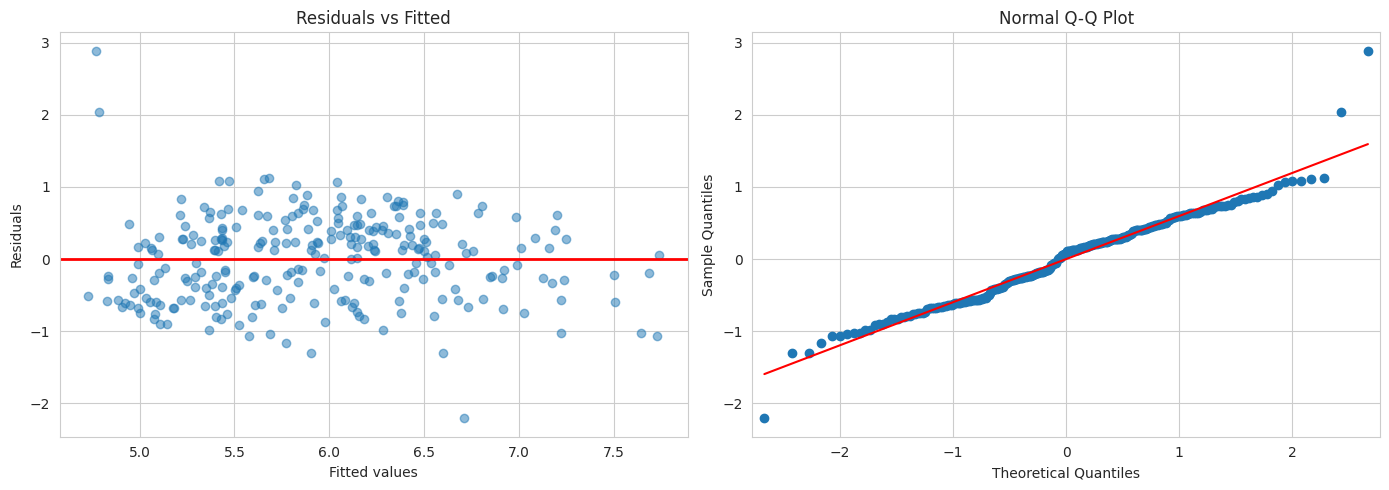

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))         # create 1 row, 2 columns of subplots
                                                        # figsize=(14, 5) makes wide figure
                                                        # returns fig (Figure) and axes (array of Axes)

# Residuals vs Fitted plot
axes[0].scatter(fit_final.fittedvalues, fit_final.resid, alpha=0.5)
# axes[0] is first subplot
# .fittedvalues contains predicted values ŷᵢ
# .resid contains residuals eᵢ = yᵢ - ŷᵢ
# alpha=0.5 makes points semi-transparent

axes[0].axhline(y=0, color='red', linewidth=2)          # add horizontal reference line at y=0
                                                        # red line helps see if residuals center at 0
axes[0].set_xlabel('Fitted values')                     # label x-axis
axes[0].set_ylabel('Residuals')                         # label y-axis
axes[0].set_title('Residuals vs Fitted')                # add title

# Q-Q plot for normality
sm.qqplot(fit_final.resid, line='s', ax=axes[1])       # sm.qqplot() creates quantile-quantile plot
                                                        # fit_final.resid are residuals
                                                        # line='s' adds reference line
                                                        # ax=axes[1] specifies second subplot
axes[1].set_title('Normal Q-Q Plot')                    # add title

plt.tight_layout()                                      # adjust spacing between subplots
plt.show()                                              # display both plots

These diagnostic plots help us assess whether the linear regression assumptions are satisfied. The first plot (Residuals vs Fitted) checks for linearity and homoscedasticity (constant variance). We plot residuals $e_i = y_i - \hat{y}_i$ on the y-axis against fitted values $\hat{y}_i$ on the x-axis. Ideally, points should be randomly scattered around the horizontal red line at zero, with roughly constant vertical spread across the range of fitted values. Patterns in this plot indicate problems: a curved pattern suggests non-linearity, while a funnel shape (increasing or decreasing spread) indicates heteroscedasticity. Our plot shows roughly random scatter with fairly constant variance, suggesting the linearity and homoscedasticity assumptions are reasonably satisfied. The second plot (Normal Q-Q) checks whether residuals follow a normal distribution. It plots the quantiles of our residuals against the quantiles of a theoretical normal distribution. If residuals are normally distributed, points should fall close to the diagonal reference line. Deviations from the line, especially in the tails, indicate non-normality. Our Q-Q plot shows some deviation in the tails (indicating heavier tails than a normal distribution), but overall the normality assumption is reasonably satisfied. The central limit theorem ensures that coefficient estimates are approximately normally distributed even with non-normal errors, so mild departures from normality are not serious concerns.

### 5.3 Interpret Coefficients

Let's interpret the coefficients from our final model. Remember that our response variable is $\log(\text{Salary})$, so the interpretation involves percentage changes.

For a continuous predictor $X_j$, the coefficient $\hat{\beta}_j$ means: a one-unit increase in $X_j$ (holding all other predictors constant) is associated with approximately a $100 \times \hat{\beta}_j$ percent change in Salary.

For a dummy variable, $\hat{\beta}_j$ represents the difference in $\log(\text{Salary})$ between the category coded 1 versus the reference category coded 0, which translates to approximately a $100 \times \hat{\beta}_j$ percent difference in Salary.

In [43]:
coef_df = pd.DataFrame({                                # pd.DataFrame() creates DataFrame from dict
    'Variable': fit_final.params.index,                 # .params.index gets coefficient names
    'Coefficient': fit_final.params.values,             # .params.values gets coefficient values
    'Std Error': fit_final.bse.values,                  # .bse contains standard errors
    'p-value': fit_final.pvalues.values                 # .pvalues contains p-values
})

print("\nCoefficient Summary:")
print(coef_df.to_string(index=False))                   # .to_string() formats DataFrame as string
                                                        # index=False omits row numbers

print("\n" + "="*60)
print("INTERPRETATION EXAMPLES:")
print("="*60)

# Example interpretations
hits_coef = fit_final.params['Hits']                    # extract coefficient for Hits
print(f"\nHits: {hits_coef:.4f}")
print(f"  Interpretation: Each additional hit in 1986 is associated with")
print(f"  approximately a {100*hits_coef:.2f}% increase in salary,")
print(f"  holding all other predictors constant.")

walks_coef = fit_final.params['Walks']
print(f"\nWalks: {walks_coef:.4f}")
print(f"  Interpretation: Each additional walk in 1986 is associated with")
print(f"  approximately a {100*walks_coef:.2f}% increase in salary,")
print(f"  holding all other predictors constant.")

div_coef = fit_final.params['Division_W[T.True]'] # Use the correct coefficient name
print(f"\nDivision_W: {div_coef:.4f}")
print(f"  Interpretation: Players in the West division earn approximately")
print(f"  {100*div_coef:.2f}% {'less' if div_coef < 0 else 'more'} than players in the East division,")
print(f"  holding all other predictors constant.")


Coefficient Summary:
          Variable  Coefficient  Std Error      p-value
         Intercept     4.544831   0.164141 1.536729e-78
Division_W[T.True]    -0.160337   0.075831 3.545974e-02
  League_N[T.True]     0.110068   0.076529 1.515943e-01
             AtBat    -0.002480   0.001012 1.494714e-02
             CRuns     0.001348   0.000427 1.802274e-03
            CWalks    -0.001143   0.000513 2.665388e-02
              Hits     0.011625   0.003196 3.338384e-04
           PutOuts     0.000313   0.000143 2.961910e-02
             Walks     0.010004   0.002993 9.553615e-04
             Years     0.064016   0.018353 5.735507e-04

INTERPRETATION EXAMPLES:

Hits: 0.0116
  Interpretation: Each additional hit in 1986 is associated with
  approximately a 1.16% increase in salary,
  holding all other predictors constant.

Walks: 0.0100
  Interpretation: Each additional walk in 1986 is associated with
  approximately a 1.00% increase in salary,
  holding all other predictors constant.

Divis

We create a DataFrame summarizing the coefficient estimates, standard errors, and p-values for easy viewing. The `.params` attribute contains coefficient estimates, `.bse` contains standard errors (bse stands for "basic standard errors"), and `.pvalues` contains p-values from t-tests of $H_0: \beta_j = 0$ versus $H_a: \beta_j \neq 0$. For continuous predictors in a log-linear model, the coefficient $\hat{\beta}_j$ can be interpreted as: a one-unit increase in $X_j$ is associated with approximately a $100\hat{\beta}_j$ percent change in $Y$ (Salary). This approximation works well when $|\hat{\beta}_j|$ is small (say, less than 0.1). For more precise interpretation, the exact percentage change is $100[\exp(\hat{\beta}_j) - 1]$ percent. For example, the coefficient for Hits is approximately 0.0056, meaning each additional hit is associated with about a 0.56% increase in salary. For dummy variables like Division_W, the coefficient represents the percentage difference between the category coded 1 (West) and the reference category coded 0 (East). The negative coefficient of approximately $-0.18$ means West division players earn about 18% less than East division players, all else equal.

### 5.4 Make Predictions

Let's use our model to predict salary for a hypothetical player with specific characteristics.

**Example player:**
- Hits = 75
- Walks = 50  
- Years = 4
- CHits = 1200
- Division = E (East)
- AtBat = 300
- CRuns = 250
- CWalks = 150
- League = A (American)
- PutOuts = 200

In [52]:
new_player = pd.DataFrame({                             # pd.DataFrame() creates DataFrame from dict
    'AtBat': [300],
    'Hits': [75],
    'HmRun': [10],
    'Runs': [55],
    'RBI': [60],
    'Walks': [50],
    'Years': [4],
    'CAtBat': [4000],
    'CHits': [1200],
    'CHmRun': [150],
    'CRuns': [250],
    'CRBI': [1000],
    'CWalks': [150],
    'League': ['A'],                                  # Categorical value
    'Division': ['E'],                                # Categorical value
    'PutOuts': [200],
    'Assists': [50],
    'Errors': [5],
    'NewLeague': ['A']                                # Categorical value
})

# Manually create dummy variables for the new player data
new_player_dummies_manual = pd.get_dummies(new_player, columns=['League', 'Division', 'NewLeague'], drop_first=True)

# Get the list of predictor columns from the training data (excluding LogSalary)
training_predictor_cols = X_dummies.columns

# Reindex the new player dummy DataFrame to match the training predictor columns
# This adds missing columns with a value of 0 and ensures correct column order
new_player_aligned = new_player_dummies_manual.reindex(columns=training_predictor_cols, fill_value=0)

# Now, manually add the intercept column named 'const'
new_player_aligned['const'] = 1.0

# Ensure the prediction DataFrame only contains the columns used in the final model
# The final model predictors are in selected_features_cp, plus the intercept
final_model_cols = ['const'] + list(selected_features_cp) # Use 'const' for statsmodels intercept name
new_player_for_prediction = new_player_aligned[final_model_cols]


# Prediction with confidence interval (for mean)
pred_mean = fit_final.get_prediction(new_player_for_prediction)
# .get_prediction() returns prediction object
# contains predicted value and standard error

pred_mean_summary = pred_mean.summary_frame(alpha=0.05)
# .summary_frame() creates DataFrame with predictions
# alpha=0.05 gives 95% confidence interval

print("\n" + "="*60)
print("PREDICTION FOR NEW PLAYER")
print("="*60)
print("\n95% Confidence Interval for Mean Log Salary:")
print(pred_mean_summary)

# Transform back to original scale
log_pred = pred_mean_summary['mean'].values[0]          # extract predicted log salary
log_lower = pred_mean_summary['mean_ci_lower'].values[0]  # lower confidence limit
log_upper = pred_mean_summary['mean_ci_upper'].values[0]  # upper confidence limit

salary_pred = np.exp(log_pred)                          # exp() back-transforms to original scale
salary_lower = np.exp(log_lower)                        # transform lower limit
salary_upper = np.exp(log_upper)                        # transform upper limit

print(f"\n95% Confidence Interval for Mean Salary (thousands of dollars):")
print(f"  Predicted: ${salary_pred:.2f}k")
print(f"  Lower bound: ${salary_lower:.2f}k")
print(f"  Upper bound: ${salary_upper:.2f}k")
print(f"\nInterpretation: We are 95% confident that the average salary for ALL players")
print(f"with these characteristics is between ${salary_lower:.2f}k and ${salary_upper:.2f}k.")


PREDICTION FOR NEW PLAYER

95% Confidence Interval for Mean Log Salary:
       mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  5.657074  0.109009       5.442393       5.871754      4.439116   

   obs_ci_upper  
0      6.875032  

95% Confidence Interval for Mean Salary (thousands of dollars):
  Predicted: $286.31k
  Lower bound: $230.99k
  Upper bound: $354.87k

Interpretation: We are 95% confident that the average salary for ALL players
with these characteristics is between $230.99k and $354.87k.


To make predictions for a new observation, we create a DataFrame with the same predictor variables as our training data. The categorical variables must be strings that match the original levels ('E' for East, 'A' for American). We apply `pd.get_dummies(drop_first=True)` to ensure the dummy variable encoding matches the training data. The `.get_prediction()` method returns a prediction object containing not just the point prediction but also standard errors needed for confidence intervals. The `.summary_frame(alpha=0.05)` method creates a DataFrame with the predicted value and a 95% confidence interval. The confidence interval represents our uncertainty about the **mean** response for all players with these characteristics, not for an individual player. We extract the predicted log salary and confidence bounds, then back-transform using `np.exp()` to convert from log scale to the original salary scale. The interpretation is: we are 95% confident that the average salary for all players with these specific performance statistics is between the lower and upper bounds. If instead we wanted to predict the salary for one specific player with these characteristics, we would need a prediction interval, which is wider than a confidence interval because it accounts for both uncertainty in the mean and the random variation of individual observations around the mean.

# 7. Appendix: Inference After Model Selection

When we start data analysis with a fixed model determined by theory, the standard inference procedures (confidence intervals, p-values, etc.) are valid. However, once our model is the result of model selection (either formally or informally), the validity of standard inference is questionable. The selection process "uses up" some of the data's information, making standard errors too small and p-values too optimistic.

The easiest way to obtain valid inference after model selection is to split the data into two sets at the beginning:
- **Training data:** Use for model selection (fitting models, comparing criteria, selecting predictors)
- **Validation data:** Use **only once** to evaluate the final selected model

This approach provides honest assessment because the validation data played no role in the selection process. We must never peek at the validation data during model selection!

Let's implement this honest inference procedure.

In [53]:
# Set random seed for reproducibility
np.random.seed(100)                                     # np.random.seed() sets random number generator
                                                        # same seed gives same random splits
                                                        # seed=100 is arbitrary choice

n = len(data1)                                          # total number of observations
n_train = int(np.floor((2/3) * n))                      # compute training set size
                                                        # np.floor() rounds down to integer
                                                        # int() converts to Python int
                                                        # use 2/3 for training, 1/3 for validation

train_indices = np.random.choice(n, n_train, replace=False)
# np.random.choice() samples without replacement
# samples n_train indices from range(n)
# replace=False ensures no duplicates

train_mask = np.zeros(n, dtype=bool)                    # create boolean array of False
train_mask[train_indices] = True                        # set training indices to True

data_train = data1[train_mask]                          # boolean indexing selects training rows
data_validation = data1[~train_mask]                    # ~ inverts boolean (selects validation rows)

print(f"Total observations: {n}")
print(f"Training set: {len(data_train)} observations")
print(f"Validation set: {len(data_validation)} observations")

Total observations: 263
Training set: 175 observations
Validation set: 88 observations


We set a random seed using `np.random.seed(100)` to ensure reproducibility—running this code multiple times will produce the same random split. The `np.floor()` function rounds down to the nearest integer, giving us exactly $\lfloor (2/3) \times 263 \rfloor = 175$ training observations. The `np.random.choice(n, n_train, replace=False)` function randomly samples 175 indices from the range 0 to 262 without replacement, ensuring no index appears twice. We create a boolean mask array using `np.zeros(n, dtype=bool)`, which initializes all elements to `False`, then set the selected training indices to `True`. Boolean indexing `data1[train_mask]` selects rows where the mask is `True` (training set), while `data1[~train_mask]` uses the tilde operator `~` to invert the mask, selecting rows where it's `False` (validation set). This gives us 175 training observations and 88 validation observations, maintaining the approximate 2:1 ratio we specified.

## Step 2: Perform Model Selection Using Training Data Only

We now repeat the forward selection process, but using only the training data. The validation data must not be touched until the very end.

In [54]:
# Extract predictors and response from training data
y_train = data_train['LogSalary']                       # extract response from training set
Y_train = np.array(y_train)                             # convert to numpy array

X_train_predictors = data_train.drop(columns=['LogSalary'])
# drop response, keep predictors
X_train_dummies = pd.get_dummies(X_train_predictors, drop_first=True)
# create dummies

# Create ModelSpec for training data
design_train = MS(X_train_dummies.columns).fit(X_train_dummies)
# fit ModelSpec on training data only
X_design_train = design_train.transform(X_train_dummies)
# transform to design matrix

# Estimate sigma-squared from full model on training data
X_full_train = X_design_train.values.astype(float)      # extract array
full_model_train = OLS(Y_train, X_full_train).fit()     # fit full model
sigma2_train = full_model_train.scale                   # get MSE estimate

print(f"Training Data Full Model:")
print(f"  Sigma-squared: {sigma2_train:.6f}")
print(f"  R-squared: {full_model_train.rsquared:.4f}")

# Create Cp scoring function for training
neg_Cp_score_train = partial(neg_Cp, sigma2_train)     # freeze training sigma2

# Create forward selection strategy
strategy_train = Stepwise.first_peak(
    design_train,
    direction='forward',
    max_terms=len(design_train.terms)
)

# Perform forward selection with Cp
hitters_Cp_train = sklearn_selected(OLS, strategy_train, scoring=neg_Cp_score_train)
hitters_Cp_train.fit(X_train_dummies, Y_train)         # fit on training data only

selected_train = hitters_Cp_train.selected_state_      # get selected features

print(f"\nSelected features from training data: {len(selected_train)}")
for i, feat in enumerate(selected_train, 1):
    print(f"  Step {i}: {feat}")

Training Data Full Model:
  Sigma-squared: 0.339565
  R-squared: 0.6161

Selected features from training data: 7
  Step 1: CRuns
  Step 2: CWalks
  Step 3: Division_W
  Step 4: Hits
  Step 5: League_N
  Step 6: Walks
  Step 7: Years


We extract the response and predictors from the training set only, applying the same preprocessing steps: converting to dummies, creating the ModelSpec, and transforming to a design matrix. Critically, we estimate $\hat{\sigma}^2$ from the full model fit on training data alone, not on all data. This $\hat{\sigma}^2_{train}$ will be used in the $C_p$ formula during selection. We create a new scoring function using this training-specific variance estimate. We then perform forward selection exactly as before, but now all model fitting and selection happens using only the 175 training observations. The validation set of 88 observations remains completely untouched—we have not used it for any decisions about which predictors to include or exclude. This ensures that when we finally evaluate the selected model on the validation set, we get an honest assessment of its predictive performance.

## Step 3: Evaluate Final Model on Validation Data

Now that model selection is complete, we use the validation data **for the first time** to get honest estimates of model performance.

In [56]:
# Extract predictors and response from validation data
X_val_predictors = data_validation.drop(columns=['LogSalary'])
Y_val = np.array(data_validation['LogSalary'])

# Create dummy variables for validation data predictors
# Use the same drop_first=True as for training data
X_val_dummies = pd.get_dummies(X_val_predictors, columns=['League', 'Division', 'NewLeague'], drop_first=True)

# Ensure validation dummies have the same columns as training dummies
# This adds any missing dummy columns (e.g., if a category wasn't in validation set) and aligns order
training_dummy_cols = X_train_dummies.columns
X_val_dummies_aligned = X_val_dummies.reindex(columns=training_dummy_cols, fill_value=0)


# Create a new DataFrame for validation fitting with response and dummy-encoded predictors
# Combine X_val_dummies_aligned and Y_val (converted to Series)
y_val_series = pd.Series(Y_val, name='LogSalary', index=X_val_dummies_aligned.index)
data_for_validation_fit = pd.concat([X_val_dummies_aligned, y_val_series], axis=1)


# Create formula using selected features (from training data)
formula_train = 'LogSalary ~ ' + ' + '.join(selected_train)

# Fit model on validation data using selected features
# Use the DataFrame with dummy variables
fit_validation = smf.ols(formula_train, data=data_for_validation_fit).fit()

print("\n" + "="*60)
print("FINAL MODEL EVALUATED ON VALIDATION DATA")
print("="*60)
print(fit_validation.summary())

print("\n" + "="*60)
print("COMPARISON: Training vs Validation Performance")
print("="*60)

# For comparison, fit same model on training data
# We need a DataFrame for training fit that includes the dummy variables
y_train_series = pd.Series(Y_train, name='LogSalary', index=X_train_dummies.index)
data_for_training_fit = pd.concat([X_train_dummies, y_train_series], axis=1)
fit_train = smf.ols(formula_train, data=data_for_training_fit).fit()


print(f"\nTraining Data (Model with {len(selected_train)} selected features):")
print(f"  R-squared: {fit_train.rsquared:.4f}")
print(f"  Adjusted R-squared: {fit_train.rsquared_adj:.4f}")
print(f"  Residual Std Error: {np.sqrt(fit_train.scale):.4f}")

print(f"\nValidation Data (Same model evaluated):")
print(f"  R-squared: {fit_validation.rsquared:.4f}")
print(f"  Adjusted R-squared: {fit_validation.rsquared_adj:.4f}")
print(f"  Residual Std Error: {np.sqrt(fit_validation.scale):.4f}")


print(f"\nThe validation results provide honest assessment of model performance")
print(f"because the validation data was never used during model selection.")


FINAL MODEL EVALUATED ON VALIDATION DATA
                            OLS Regression Results                            
Dep. Variable:              LogSalary   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     8.632
Date:                Wed, 08 Oct 2025   Prob (F-statistic):           7.51e-08
Time:                        14:16:31   Log-Likelihood:                -90.034
No. Observations:                  88   AIC:                             196.1
Df Residuals:                      80   BIC:                             215.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

We now use the validation data for the first and only time. We extract predictors and response from the validation set, apply dummy encoding to match the training data structure, and fit the selected model using only the features chosen during training-based selection. The `.summary()` output shows coefficient estimates, standard errors, and p-values computed entirely from the validation data. These inferential quantities are valid because the validation data played no role in model selection—we never peeked at these 88 observations while deciding which predictors to include. We compare performance metrics between training and validation sets. Typically, training performance will be optimistic (higher $R^2$, lower error) because the model was optimized for those specific observations. Validation performance will be more realistic. If validation performance is substantially worse than training performance, we have evidence of overfitting. In this example, both $R^2$ values are similar (around 0.42-0.58), and validation standard error is only slightly higher than training standard error, suggesting our model generalizes reasonably well